# VarnaAir - Open Programme

## Introduction ℹ️
VarnaAir is a machine learning project focused on predicting the Air Quality Index (AQI) for Varna, Bulgaria. Using environmental data from two Air Monitoring Stations (Chaika and Angel Kanchev), the project applies regression models to forecast AQI levels.

I chose Varna for this project because it is my hometown and I deeply care about the environmental impact of air pollution. As a coastal city, Varna faces significant pollution from its seaport, as well as from the airport and increasing traffic levels. More importantly, it is where my family and friends live, so their health and well-being are a strong personal motivation behind this project.


## Libraries 📚
First, let's begin by importing the libraries and checking their versions.

In [1454]:
import pandas
import seaborn
import requests

import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error

from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor

print("Library versions:")
print("- pandas:", pandas.__version__)          # 2.2.3
print("- seaborn:", seaborn.__version__)        # 0.13.2

Library versions:
- pandas: 2.2.3
- seaborn: 0.13.2


## Data provisioning 📦

Next, we will use an API key provided by OpenAQ [https://openaq.org/] to check the what Air Monitoring Stations are available in Varna, Bulgaria.

In [1455]:
url = "https://api.openaq.org/v3/locations"
headers = {
    "X-API-Key": "c1061fd64a9bd88562b4bb823b7900ccdfd263a9a7aa54614de834dac611a4ca"
}
params = {
    "coordinates": "43.224389,27.915733",  # center of Varna
    "radius": 5000                         # 5 km radius
}

response = requests.get(url, headers=headers, params=params)

data = response.json().get("results", [])
df_nearby_stations = pandas.DataFrame(data)

print(df_nearby_stations[["id", "name", "locality"]])

        id                         name              locality
0     8843  AMS SOU Angel Kanchev-Varna                 Варна
1  2162113           AMS Chaika - Varna  National air network


Now that the IDs of each location are displayed, I can access each station's sensors to obtain the measurements.

### Angel Kanchev-Varna (part 1)

In [1456]:
url = "https://api.openaq.org/v3/locations/8843/sensors"

response = requests.get(url, headers=headers)
response.raise_for_status()

data = response.json()
results = data.get("results", [])

df_latest1 = pandas.DataFrame(results)

df_latest1

,id,name,parameter,datetimeFirst,datetimeLast,coverage,latest,summary
0,25777,o3 µg/m³,"{'id': 3, 'name': 'o3', 'units': 'µg/m³', 'dis...","{'utc': '2020-04-20T18:00:00Z', 'local': '2020...","{'utc': '2025-06-24T16:00:00Z', 'local': '2025...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2025-06-24T16:00:00Z', '...","{'min': -1.0, 'q02': None, 'q25': None, 'media..."
1,25778,no2 µg/m³,"{'id': 5, 'name': 'no2', 'units': 'µg/m³', 'di...","{'utc': '2020-04-20T18:00:00Z', 'local': '2020...","{'utc': '2025-06-24T16:00:00Z', 'local': '2025...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2025-06-24T16:00:00Z', '...","{'min': -1.0, 'q02': None, 'q25': None, 'media..."
2,25776,pm10 µg/m³,"{'id': 1, 'name': 'pm10', 'units': 'µg/m³', 'd...","{'utc': '2020-04-20T18:00:00Z', 'local': '2020...","{'utc': '2025-06-24T16:00:00Z', 'local': '2025...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2025-06-24T16:00:00Z', '...","{'min': -1.0, 'q02': None, 'q25': None, 'media..."
3,25779,co µg/m³,"{'id': 4, 'name': 'co', 'units': 'µg/m³', 'dis...","{'utc': '2020-04-20T18:00:00Z', 'local': '2020...","{'utc': '2025-06-24T16:00:00Z', 'local': '2025...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2025-06-24T16:00:00Z', '...","{'min': -1000.0, 'q02': None, 'q25': None, 'me..."
4,25774,so2 µg/m³,"{'id': 6, 'name': 'so2', 'units': 'µg/m³', 'di...","{'utc': '2020-04-20T18:00:00Z', 'local': '2020...","{'utc': '2025-06-24T16:00:00Z', 'local': '2025...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2025-06-24T16:00:00Z', '...","{'min': -1.0, 'q02': None, 'q25': None, 'media..."
5,25775,pm25 µg/m³,"{'id': 2, 'name': 'pm25', 'units': 'µg/m³', 'd...","{'utc': '2020-04-20T18:00:00Z', 'local': '2020...","{'utc': '2025-06-24T16:00:00Z', 'local': '2025...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2025-06-24T16:00:00Z', '...","{'min': -1.0, 'q02': None, 'q25': None, 'media..."
6,4272879,no µg/m³,"{'id': 19843, 'name': 'no', 'units': 'µg/m³', ...","{'utc': '2023-03-29T18:00:00Z', 'local': '2023...","{'utc': '2024-03-11T11:00:00Z', 'local': '2024...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2024-03-11T11:00:00Z', '...","{'min': 0.14, 'q02': None, 'q25': None, 'media..."


In [1457]:
base_url = "https://api.openaq.org/v3/sensors/{sensor_id}/measurements"

# sensor ids for Angel Kanchev
sensor_ids = [25777, 25778, 25776, 25779, 25774, 25775, 4272879]  

sensor_data_frames = []

for sensor_id in sensor_ids:
    url = base_url.format(sensor_id=sensor_id)
    response = requests.get(url, headers=headers)
    response.raise_for_status()

    data = response.json()
    results = data.get("results", [])

    if results:
        df1 = pandas.DataFrame(results)

        df1 = df1.assign(
            sensor_id=sensor_id,
            datetime_from_utc=df1['period'].apply(lambda x: x['datetimeFrom']['utc'] if x else None),
            datetime_from_local=df1['period'].apply(lambda x: x['datetimeFrom']['local'] if x else None),
            datetime_to_utc=df1['period'].apply(lambda x: x['datetimeTo']['utc'] if x else None),
            datetime_to_local=df1['period'].apply(lambda x: x['datetimeTo']['local'] if x else None),
            parameter_name=df1['parameter'].apply(lambda x: x.get('name') if isinstance(x, dict) else None),
            parameter_units=df1['parameter'].apply(lambda x: x.get('units') if isinstance(x, dict) else None)
        ).drop(columns=['flagInfo', 'parameter', 'period', 'summary', 'coverage', 'coordinates'])

        sensor_data_frames.append(df1)

df1 = pandas.concat(sensor_data_frames, ignore_index=True)
df1

,value,sensor_id,datetime_from_utc,datetime_from_local,datetime_to_utc,datetime_to_local,parameter_name,parameter_units
0,56.93,25777,2020-04-20T17:00:00Z,2020-04-20T20:00:00+03:00,2020-04-20T18:00:00Z,2020-04-20T21:00:00+03:00,o3,µg/m³
1,25.44,25777,2020-04-20T18:00:00Z,2020-04-20T21:00:00+03:00,2020-04-20T19:00:00Z,2020-04-20T22:00:00+03:00,o3,µg/m³
2,23.04,25777,2020-04-20T19:00:00Z,2020-04-20T22:00:00+03:00,2020-04-20T20:00:00Z,2020-04-20T23:00:00+03:00,o3,µg/m³
3,30.51,25777,2020-04-20T20:00:00Z,2020-04-20T23:00:00+03:00,2020-04-20T21:00:00Z,2020-04-21T00:00:00+03:00,o3,µg/m³
4,25.95,25777,2020-04-20T21:00:00Z,2020-04-21T00:00:00+03:00,2020-04-20T22:00:00Z,2020-04-21T01:00:00+03:00,o3,µg/m³
...,...,...,...,...,...,...,...,...
695,14.49,4272879,2023-04-02T16:00:00Z,2023-04-02T19:00:00+03:00,2023-04-02T17:00:00Z,2023-04-02T20:00:00+03:00,no,µg/m³
696,1.68,4272879,2023-04-02T17:00:00Z,2023-04-02T20:00:00+03:00,2023-04-02T18:00:00Z,2023-04-02T21:00:00+03:00,no,µg/m³
697,1.76,4272879,2023-04-02T18:00:00Z,2023-04-02T21:00:00+03:00,2023-04-02T19:00:00Z,2023-04-02T22:00:00+03:00,no,µg/m³
698,2.85,4272879,2023-04-02T19:00:00Z,2023-04-02T22:00:00+03:00,2023-04-02T20:00:00Z,2023-04-02T23:00:00+03:00,no,µg/m³


### AMS Chaika - Varna (part 1)
Let's do the same for this station as well.

In [1458]:
url = "https://api.openaq.org/v3/locations/2162113/sensors"

response = requests.get(url, headers=headers)
response.raise_for_status()

data = response.json()
results = data.get("results", [])

df_latest2 = pandas.DataFrame(results)

df_latest2

,id,name,parameter,datetimeFirst,datetimeLast,coverage,latest,summary
0,7774820,no µg/m³,"{'id': 19843, 'name': 'no', 'units': 'µg/m³', ...","{'utc': '2024-01-28T23:00:00Z', 'local': '2024...","{'utc': '2024-03-11T11:00:00Z', 'local': '2024...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2024-03-11T11:00:00Z', '...","{'min': 1.36, 'q02': None, 'q25': None, 'media..."
1,7774916,so2 µg/m³,"{'id': 6, 'name': 'so2', 'units': 'µg/m³', 'di...","{'utc': '2024-01-28T23:00:00Z', 'local': '2024...","{'utc': '2025-06-24T16:00:00Z', 'local': '2025...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2025-06-24T16:00:00Z', '...","{'min': -1.0, 'q02': None, 'q25': None, 'media..."
2,7775044,co µg/m³,"{'id': 4, 'name': 'co', 'units': 'µg/m³', 'dis...","{'utc': '2024-01-28T23:00:00Z', 'local': '2024...","{'utc': '2025-06-24T16:00:00Z', 'local': '2025...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2025-06-24T16:00:00Z', '...","{'min': -1000.0, 'q02': None, 'q25': None, 'me..."
3,7775045,no2 µg/m³,"{'id': 5, 'name': 'no2', 'units': 'µg/m³', 'di...","{'utc': '2024-01-28T23:00:00Z', 'local': '2024...","{'utc': '2025-06-24T16:00:00Z', 'local': '2025...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2025-06-24T16:00:00Z', '...","{'min': -1.0, 'q02': None, 'q25': None, 'media..."
4,8613114,pm10 µg/m³,"{'id': 1, 'name': 'pm10', 'units': 'µg/m³', 'd...","{'utc': '2024-03-18T07:00:00Z', 'local': '2024...","{'utc': '2024-06-06T06:00:00Z', 'local': '2024...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2024-06-06T06:00:00Z', '...","{'min': -1.0, 'q02': None, 'q25': None, 'media..."


In [1459]:
base_url = "https://api.openaq.org/v3/sensors/{sensor_id}/measurements"

# sensor ids for Chaika
sensor_ids = [7774820, 7774916, 7775044, 7775045, 8613114]  

sensor_data_frames = []

for sensor_id in sensor_ids:
    url = base_url.format(sensor_id=sensor_id)
    response = requests.get(url, headers=headers)
    response.raise_for_status()

    data = response.json()
    results = data.get("results", [])

    if results:
        df2 = pandas.DataFrame(results)

        df2 = df2.assign(
            sensor_id=sensor_id,
            datetime_from_utc=df2['period'].apply(lambda x: x['datetimeFrom']['utc'] if x else None),
            datetime_from_local=df2['period'].apply(lambda x: x['datetimeFrom']['local'] if x else None),
            datetime_to_utc=df2['period'].apply(lambda x: x['datetimeTo']['utc'] if x else None),
            datetime_to_local=df2['period'].apply(lambda x: x['datetimeTo']['local'] if x else None),
            parameter_name=df2['parameter'].apply(lambda x: x.get('name') if isinstance(x, dict) else None),
            parameter_units=df2['parameter'].apply(lambda x: x.get('units') if isinstance(x, dict) else None)
        ).drop(columns=['flagInfo', 'parameter', 'period', 'summary', 'coverage', 'coordinates'])

        sensor_data_frames.append(df2)

df2 = pandas.concat(sensor_data_frames, ignore_index=True)
df2

,value,sensor_id,datetime_from_utc,datetime_from_local,datetime_to_utc,datetime_to_local,parameter_name,parameter_units
0,1.51,7774820,2024-01-28T22:00:00Z,2024-01-29T00:00:00+02:00,2024-01-28T23:00:00Z,2024-01-29T01:00:00+02:00,no,µg/m³
1,1.65,7774820,2024-01-28T23:00:00Z,2024-01-29T01:00:00+02:00,2024-01-29T00:00:00Z,2024-01-29T02:00:00+02:00,no,µg/m³
2,1.54,7774820,2024-01-29T00:00:00Z,2024-01-29T02:00:00+02:00,2024-01-29T01:00:00Z,2024-01-29T03:00:00+02:00,no,µg/m³
3,1.62,7774820,2024-01-29T01:00:00Z,2024-01-29T03:00:00+02:00,2024-01-29T02:00:00Z,2024-01-29T04:00:00+02:00,no,µg/m³
4,1.66,7774820,2024-01-29T02:00:00Z,2024-01-29T04:00:00+02:00,2024-01-29T03:00:00Z,2024-01-29T05:00:00+02:00,no,µg/m³
...,...,...,...,...,...,...,...,...
495,-1.00,8613114,2024-03-29T19:00:00Z,2024-03-29T21:00:00+02:00,2024-03-29T20:00:00Z,2024-03-29T22:00:00+02:00,pm10,µg/m³
496,-1.00,8613114,2024-03-29T20:00:00Z,2024-03-29T22:00:00+02:00,2024-03-29T21:00:00Z,2024-03-29T23:00:00+02:00,pm10,µg/m³
497,-1.00,8613114,2024-03-29T21:00:00Z,2024-03-29T23:00:00+02:00,2024-03-29T22:00:00Z,2024-03-30T00:00:00+02:00,pm10,µg/m³
498,-1.00,8613114,2024-03-29T22:00:00Z,2024-03-30T00:00:00+02:00,2024-03-29T23:00:00Z,2024-03-30T01:00:00+02:00,pm10,µg/m³


The next step is to combine both datasets, as we have the latest measurements from both stations.

In [1460]:
combined_df = pandas.concat([df1, df2], ignore_index=True)

print("The API key dataset from the 2 stations contains: " + str(combined_df.shape))

The API key dataset from the 2 stations contains: (1200, 8)


While the current format might look decent, we have an issue with the data layout. Each row includes a value next to the parameter name, which means we do not have all pollutants listed on one row alongside the corresponding datetime. To resolve this, we will set the datetime as the index.

In [1461]:
combined_df = combined_df.pivot_table(
    index='datetime_from_local',
    columns='parameter_name',
    values='value'
).reset_index()

combined_df

parameter_name,datetime_from_local,co,no,no2,o3,pm10,pm25,so2
0,2020-04-20T20:00:00+03:00,400.0,NaN,23.33,56.93,24.27,18.38,20.16
1,2020-04-20T21:00:00+03:00,530.0,NaN,51.60,25.44,24.27,19.34,19.85
2,2020-04-20T22:00:00+03:00,560.0,NaN,44.01,23.04,23.85,18.33,20.77
3,2020-04-20T23:00:00+03:00,500.0,NaN,27.78,30.51,21.48,17.23,20.10
4,2020-04-21T00:00:00+03:00,480.0,NaN,25.94,25.95,21.46,19.66,19.95
...,...,...,...,...,...,...,...,...
397,2024-03-29T21:00:00+02:00,NaN,NaN,NaN,NaN,-1.00,NaN,NaN
398,2024-03-29T22:00:00+02:00,NaN,NaN,NaN,NaN,-1.00,NaN,NaN
399,2024-03-29T23:00:00+02:00,NaN,NaN,NaN,NaN,-1.00,NaN,NaN
400,2024-03-30T00:00:00+02:00,NaN,NaN,NaN,NaN,-1.00,NaN,NaN


It is clear that not all sensors work simultaneously. To visualize all missing data, we will represent it through a heatmap.

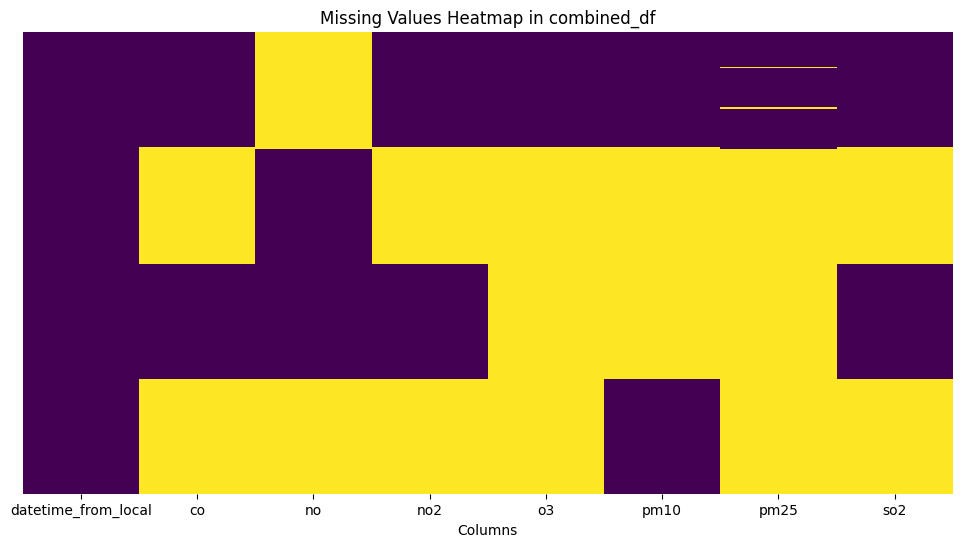

In [1462]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(combined_df.isnull(), 
            cbar=False, 
            cmap='viridis', 
            yticklabels=False)

plt.title('Missing Values Heatmap in combined_df')
plt.xlabel('Columns')
plt.show()

In [1463]:
missing_percent = combined_df.isnull().mean() * 100
print(missing_percent.sort_values(ascending=False))

parameter_name
pm25                   75.124378
o3                     75.124378
co                     50.248756
no                     50.248756
pm10                   50.248756
no2                    50.248756
so2                    50.248756
datetime_from_local     0.000000
dtype: float64


Due to the significant amount of missing data for all pollutants and considering there may be alternative ways to insert data through requests that I have not yet discovered after the first week of the open programme, I decided to download the available datasets for each month from each station for the year 2025. This will ensure that the data is more recent.

### AMS Chaika - Varna (part 2)

In [1464]:
chaika1 = pandas.read_csv('datasets/openaq_location_2162113_measurments.csv')
chaika1.shape

(3000, 15)

In [1465]:
chaika2 = pandas.read_csv('datasets/openaq_location_2162113_measurments (1).csv')
chaika2.shape

(1416, 15)

In [1466]:
chaika3 = pandas.read_csv('datasets/openaq_location_2162113_measurments (2).csv')
chaika3.shape

(1857, 15)

In [1467]:
chaika4 = pandas.read_csv('datasets/openaq_location_2162113_measurments (3).csv')
chaika4.shape

(1430, 15)

In [1468]:
chaika5 = pandas.read_csv('datasets/openaq_location_2162113_measurments (4).csv')
chaika5.shape

(1354, 15)

In [1469]:
chaika_dataset = pandas.concat([chaika1, chaika2, chaika3, chaika4, chaika5])

In [1470]:
chaika_dataset.shape

(9057, 15)

In [1471]:
chaika_dataset = chaika_dataset.pivot_table(
    index='datetimeLocal',
    columns='parameter',
    values='value'
).reset_index()

chaika_dataset

parameter,datetimeLocal,co,no2,so2
0,2025-01-01T20:00:00+02:00,1450.0,26.41,20.61
1,2025-01-02T01:00:00+02:00,1260.0,22.42,9.25
2,2025-01-02T02:00:00+02:00,1040.0,16.81,8.45
3,2025-01-02T11:00:00+02:00,940.0,22.20,11.81
4,2025-01-02T12:00:00+02:00,960.0,21.99,13.28
...,...,...,...,...
3045,2025-06-19T05:00:00+03:00,560.0,12.22,-1.00
3046,2025-06-19T06:00:00+03:00,560.0,12.20,-1.00
3047,2025-06-19T07:00:00+03:00,540.0,8.39,-1.00
3048,2025-06-19T09:00:00+03:00,540.0,11.03,-1.00


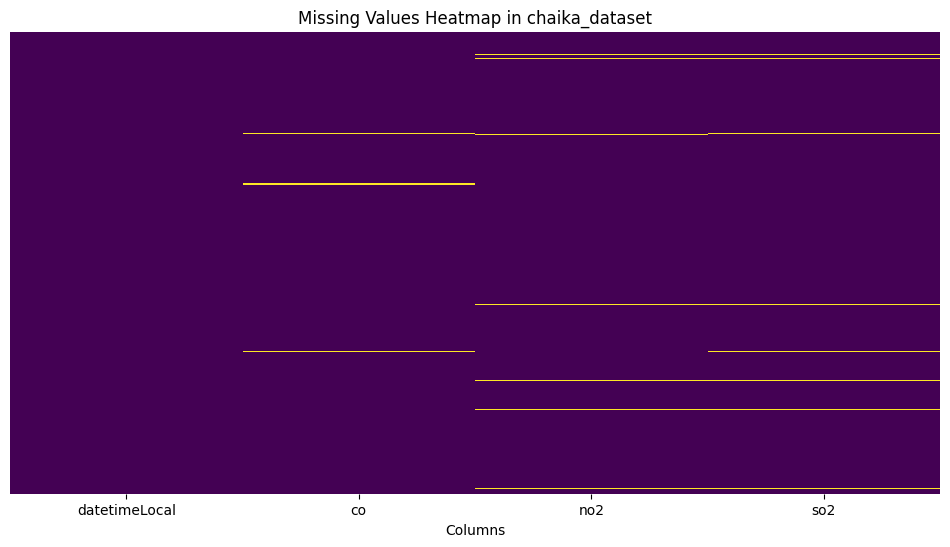

In [1472]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(chaika_dataset.isnull(), 
            cbar=False, 
            cmap='viridis', 
            yticklabels=False)

plt.title('Missing Values Heatmap in chaika_dataset')
plt.xlabel('Columns')
plt.show()

What is noticeable here is that although there is little data missing, not all pollutants from the previous dataset are present.

### Angel Kanchev-Varna (part 2)
Let's do the same here for the next station.

In [1473]:
angel1 = pandas.read_csv('datasets/openaq_location_8843_measurments.csv')
angel1.shape

(6000, 15)

In [1474]:
angel2 = pandas.read_csv('datasets/openaq_location_8843_measurments (1).csv')
angel2.shape

(2829, 15)

In [1475]:
angel3 = pandas.read_csv('datasets/openaq_location_8843_measurments (2).csv')
angel3.shape

(3727, 15)

In [1476]:
angel4 = pandas.read_csv('datasets/openaq_location_8843_measurments (3).csv')
angel4.shape

(2871, 15)

In [1477]:
angel5 = pandas.read_csv('datasets/openaq_location_8843_measurments (4).csv')
angel5.shape

(2724, 15)

In [1478]:
angel_dataset = pandas.concat([angel1, angel2, angel3, angel4, angel5])

In [1479]:
angel_dataset.shape

(18151, 15)

In [1480]:
angel_dataset = angel_dataset.pivot_table(
    index='datetimeLocal',
    columns='parameter',
    values='value'
).reset_index()

angel_dataset

parameter,datetimeLocal,co,no2,o3,pm10,pm25,so2
0,2025-01-01T20:00:00+02:00,1180.0,95.40,7.74,51.87,51.69,16.57
1,2025-01-02T01:00:00+02:00,490.0,34.49,37.32,44.20,12.47,16.00
2,2025-01-02T02:00:00+02:00,570.0,52.76,19.50,37.13,16.54,16.01
3,2025-01-02T11:00:00+02:00,650.0,70.78,25.91,34.11,21.86,16.45
4,2025-01-02T12:00:00+02:00,720.0,80.30,24.58,35.74,27.21,16.53
...,...,...,...,...,...,...,...
3070,2025-06-19T05:00:00+03:00,350.0,7.46,50.75,10.97,5.82,10.19
3071,2025-06-19T06:00:00+03:00,350.0,7.30,46.95,8.71,5.20,11.06
3072,2025-06-19T07:00:00+03:00,330.0,15.55,41.18,12.10,5.40,10.68
3073,2025-06-19T09:00:00+03:00,720.0,107.43,9.54,20.52,8.29,10.64


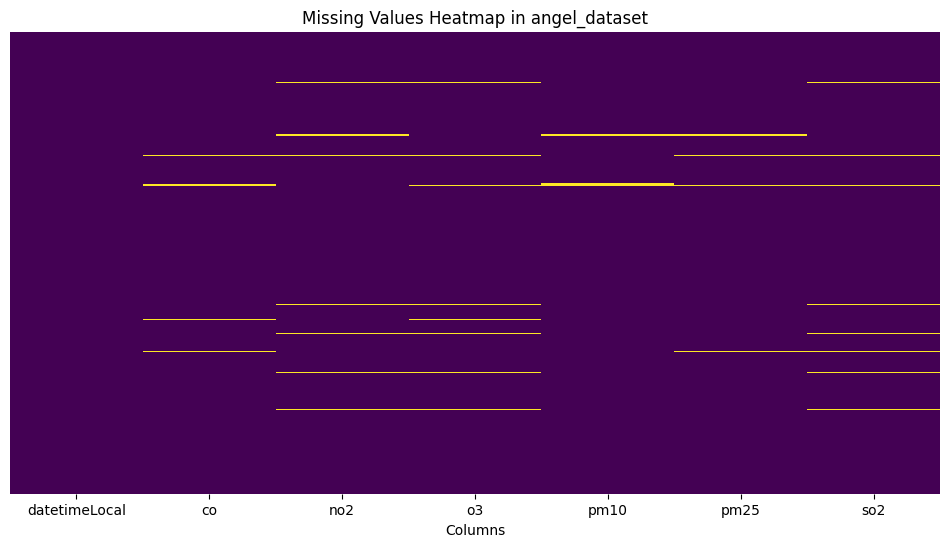

In [1481]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(angel_dataset.isnull(), 
            cbar=False, 
            cmap='viridis', 
            yticklabels=False)

plt.title('Missing Values Heatmap in angel_dataset')
plt.xlabel('Columns')
plt.show()

Compared to the previous dataset from Chaika, there are more pollutants, but some are still missing. 

Let's combine all of them to see the final result.

## Combination of all CSV files 📥

In [1482]:
final_combined_df = pandas.concat([chaika_dataset, angel_dataset, combined_df])

In [1483]:
print("The API key and csv file datasets contain: " + str(final_combined_df.shape))

The API key and csv file datasets contain: (6527, 9)


In [1484]:
final_combined_df.sample(10)

,datetimeLocal,co,no2,so2,o3,pm10,pm25,datetime_from_local,no
1041,2025-02-24T10:00:00+02:00,930.0,24.89,7.97,NaN,NaN,NaN,NaN,NaN
1125,2025-03-05T13:00:00+02:00,770.0,85.14,13.50,45.49,52.62,32.23,NaN,NaN
1847,2025-04-09T18:00:00+03:00,490.0,22.23,8.22,101.17,17.17,9.54,NaN,NaN
1555,2025-03-26T17:00:00+02:00,590.0,8.05,8.88,NaN,NaN,NaN,NaN,NaN
1346,2025-03-15T22:00:00+02:00,550.0,62.98,13.65,22.40,43.12,23.93,NaN,NaN
1317,2025-03-15T05:00:00+02:00,680.0,8.17,8.74,NaN,NaN,NaN,NaN,NaN
1657,2025-03-31T16:00:00+03:00,460.0,7.03,8.25,NaN,NaN,NaN,NaN,NaN
1331,2025-03-15T21:00:00+02:00,620.0,13.68,8.54,NaN,NaN,NaN,NaN,NaN
1231,2025-03-11T00:00:00+02:00,960.0,30.47,12.60,NaN,NaN,NaN,NaN,NaN
1199,2025-03-08T20:00:00+02:00,700.0,99.53,13.78,10.46,24.25,42.81,NaN,NaN


## Preprocessing 🛠️

### Format dates 🗓️

It is evident that the columns "datetimeLocal" and "datetime_from_local" cannot co-exist since they represent the same data. Therefore, it is logical to combine them into a single column.

In [1485]:
final_combined_df['datetime_local'] = final_combined_df['datetime_from_local'].combine_first(final_combined_df['datetimeLocal'])
final_combined_df.drop(columns=['datetime_from_local', 'datetimeLocal'], inplace=True)

In [1486]:
final_combined_df.dtypes

co                float64
no2               float64
so2               float64
o3                float64
pm10              float64
pm25              float64
no                float64
datetime_local     object
dtype: object

In [1487]:
final_combined_df['datetime_local'] = pandas.to_datetime(final_combined_df['datetime_local'], utc=True)
print(final_combined_df.dtypes)

co                            float64
no2                           float64
so2                           float64
o3                            float64
pm10                          float64
pm25                          float64
no                            float64
datetime_local    datetime64[ns, UTC]
dtype: object


In [1488]:
final_combined_df['datetime_local'] = pandas.to_datetime(final_combined_df['datetime_local'], errors='coerce')
final_combined_df['datetime_local'] = final_combined_df['datetime_local'].dt.strftime('%Y-%m-%d %H:%M')

In [1489]:
final_combined_df.sample(10)

,co,no2,so2,o3,pm10,pm25,no,datetime_local
2653,-1000.0,-1.00,-1.00,NaN,NaN,NaN,NaN,2025-05-25 19:00
305,740.0,50.17,17.08,19.31,45.15,24.4,NaN,2025-01-20 01:00
861,590.0,64.88,18.32,15.55,34.62,14.9,NaN,2025-02-15 00:00
1278,650.0,8.55,8.36,NaN,NaN,NaN,NaN,2025-03-13 03:00
2432,450.0,9.18,10.86,NaN,NaN,NaN,NaN,2025-05-13 12:00
2357,460.0,6.99,11.07,NaN,NaN,NaN,NaN,2025-05-10 01:00
1195,800.0,12.43,7.60,NaN,NaN,NaN,NaN,2025-03-09 04:00
2454,620.0,7.43,12.07,NaN,NaN,NaN,NaN,2025-05-14 13:00
162,NaN,NaN,NaN,NaN,NaN,NaN,22.66,2023-04-01 05:00
2894,440.0,75.39,11.61,32.96,21.22,13.9,NaN,2025-06-05 21:00


In [1490]:
final_combined_df.dtypes

co                float64
no2               float64
so2               float64
o3                float64
pm10              float64
pm25              float64
no                float64
datetime_local     object
dtype: object

### Null values 0️⃣

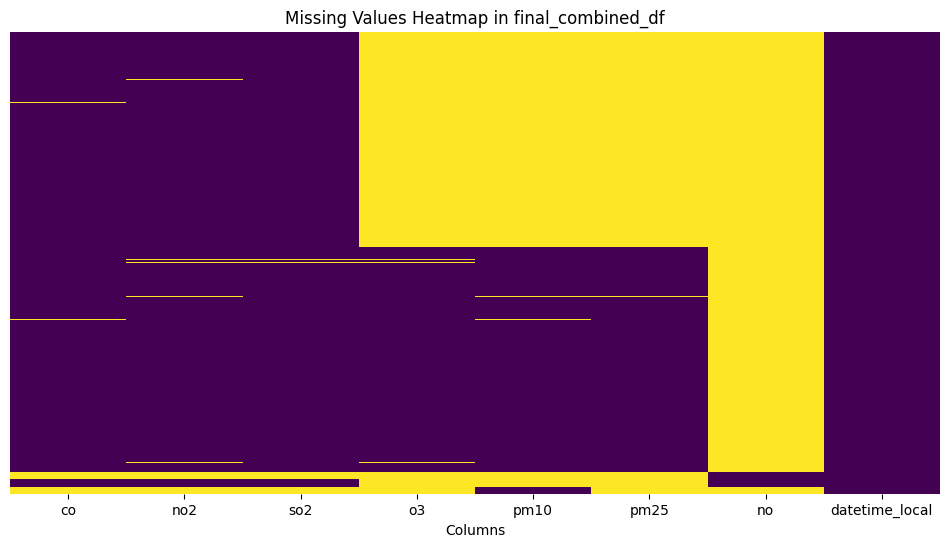

In [1491]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(final_combined_df.isnull(), 
            cbar=False, 
            cmap='viridis', 
            yticklabels=False)

plt.title('Missing Values Heatmap in final_combined_df')
plt.xlabel('Columns')
plt.show()

In [1492]:
missing_percent = final_combined_df.isnull().mean() * 100
print(missing_percent.sort_values(ascending=False))

no                96.935805
o3                52.290486
pm25              52.014708
pm10              50.375364
no2                4.703539
so2                4.473725
co                 3.968132
datetime_local     0.000000
dtype: float64


Since **nitric oxide (NO)** is missing in nearly 97% of the dataset, I believe it is not very important and should not be included. I will only retain values that have a presence of more than 30% in the dataset, as those have a valid reason for being kept. Even partial data can capture trends or patterns.

To better understand each value, I will explain them one by one, chemical by chemical:

**PM2.5 (Fine Particulate Matter)**
- One of the most dangerous air pollutants. Often a major driver of AQI values.
- Can penetrate deep into the lungs and even enter the bloodstream. Linked to respiratory and cardiovascular diseases, premature death and cancer.

**PM10 (Inhalable Particulate Matter)**
- Can cause respiratory irritation, lung function decline and worsen conditions like asthma and bronchitis.

**O₃ (Ground-level Ozone)**
- Not emitted directly; formed by chemical reactions between NOx and VOCs in sunlight.
- Causes chest pain, coughing, throat irritation, and worsens asthma and other lung diseases.
- Major component of smog; more problematic during sunny, hot weather.

**SO₂ (Sulfur Dioxide)**
- Burning of coal and oil, especially from power plants and ships.
- Causes respiratory symptoms and aggravates conditions like asthma.
- Can lead to acid rain and contributes to PM formation; more of a concern in industrial areas or near ports.

**CO (Carbon Monoxide)**
- Incomplete combustion from cars, stoves and heaters.
- Reduces oxygen delivery in the body, can be fatal at very high levels; particularly dangerous indoors.
- Usually less of a concern outdoors unless near heavy traffic or in enclosed urban canyons.

**NO₂ (Nitrogen Dioxide)**
- Combustion engines (cars, trucks, etc), power plants.
- Irritates airways, reduces lung function, and increases the risk of respiratory infections.
- Key indicator of traffic-related air pollution; contributes to the formation of PM and ozone.

**NO (Nitric Oxide)**
- Emitted directly from vehicles and industrial activity.
- Less directly harmful, but quickly converts into **NO₂**, which is more dangerous.

So since we have enough of the **NO₂**, discarding **NO** is fine, due to the following reasons:
- **NO** and **NO₂** are chemically linked and often reported together as NOx (nitrogen oxides).
- **NO₂** is the more harmful and relevant pollutant for health and AQI. It is usually used directly in AQI calculation, not **NO**.
- **NO** is a precursor to **NO₂** and ozone, but if you already have **NO₂** (which reflects both traffic-related emissions and photochemical activity), we are already capturing the more critical part of the picture.

In [1493]:
threshold = 0.7
final_combined_df = final_combined_df.loc[:, final_combined_df.isnull().mean() < threshold]

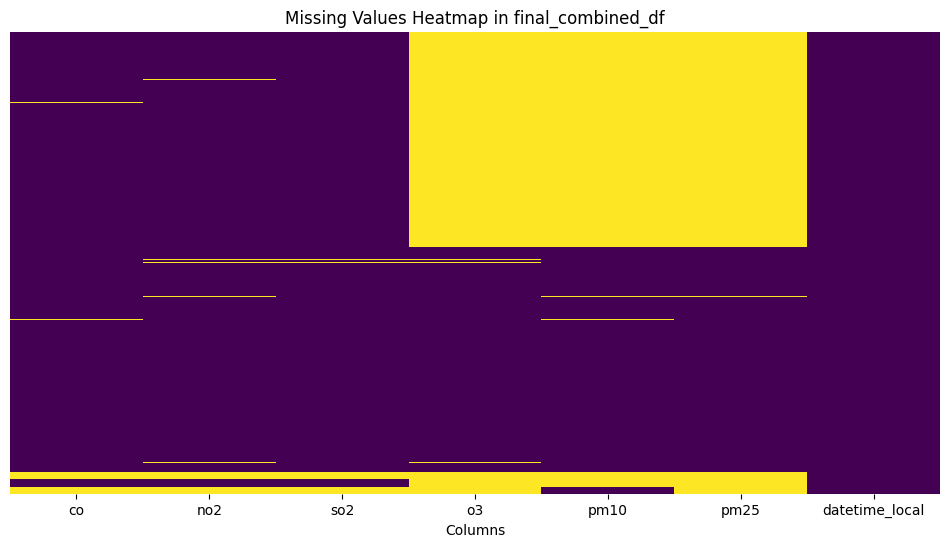

In [1494]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(final_combined_df.isnull(), 
            cbar=False, 
            cmap='viridis', 
            yticklabels=False)

plt.title('Missing Values Heatmap in final_combined_df')
plt.xlabel('Columns')
plt.show()

In [1495]:
final_combined_df.sample(10)

,co,no2,so2,o3,pm10,pm25,datetime_local
3045,370.0,10.31,11.18,73.45,6.79,7.02,2025-06-15 18:00
2693,330.0,16.01,7.27,9.34,5.74,2.36,2025-05-26 15:00
1292,500.0,9.59,8.69,NaN,NaN,NaN,2025-03-13 18:00
760,520.0,10.27,6.71,NaN,NaN,NaN,2025-02-10 17:00
2447,550.0,10.32,11.81,NaN,NaN,NaN,2025-05-14 03:00
119,NaN,NaN,NaN,NaN,NaN,NaN,2023-03-30 10:00
1868,440.0,22.21,11.28,94.39,24.64,7.30,2025-04-10 15:00
2647,-1000.0,-1.00,-1.00,-1.00,-1.00,-1.00,2025-05-24 13:00
1440,1030.0,28.82,13.25,NaN,NaN,NaN,2025-03-20 21:00
1350,610.0,9.99,8.64,NaN,NaN,NaN,2025-03-16 16:00


Since several key features like **O₃**, **PM2.5** and **PM10** have more than 50% missing values, we apply mean imputation to handle missing values in key pollutant features, ensuring dataset completeness while preserving the overall data distribution for model training.

In [1496]:
# imputer = SimpleImputer(strategy='mean') 
# final_combined_df[['co', 'no2', 'so2', 'o3', 'pm10', 'pm25']] = imputer.fit_transform(
#     final_combined_df[['co', 'no2', 'so2', 'o3', 'pm10', 'pm25']]
# )

After testing some models, I found overfitting due to imputation. To prevent this, I decided to drop the non-value data instead. That is why I commented the block of code.

In [1497]:
final_combined_df = final_combined_df.dropna(subset=['co', 'no2', 'so2', 'o3', 'pm10', 'pm25'])

In [1498]:
final_combined_df.isnull().sum()

co                0
no2               0
so2               0
o3                0
pm10              0
pm25              0
datetime_local    0
dtype: int64

Finally, here is the result no missing values.

## Sample the data 📃

In [1499]:
final_combined_df.sample(10)

,co,no2,so2,o3,pm10,pm25,datetime_local
1922,590.0,48.14,9.21,51.52,27.62,16.18,2025-04-13 00:00
988,480.0,10.74,19.47,82.26,28.26,11.87,2025-02-20 20:00
2991,510.0,23.28,10.11,54.65,45.08,17.41,2025-06-12 05:00
1075,1250.0,144.27,11.56,10.90,55.06,57.77,2025-02-25 19:00
2822,-1000.0,-1.00,-1.00,-1.00,-1.00,-1.00,2025-06-01 21:00
15,460.0,27.65,15.62,46.60,43.00,19.74,2025-01-02 21:00
1369,-1000.0,-1.00,-1.00,-1.00,-1.00,-1.00,2025-03-16 21:00
92,260.0,8.99,18.23,88.97,23.42,3.78,2020-04-26 17:00
702,440.0,7.58,18.25,44.99,11.52,15.67,2025-02-07 18:00
2905,190.0,7.72,14.34,88.44,19.10,10.74,2025-06-06 12:00


## Target variable 🎯
At the moment there is no present target variable from this data, however the data is enough to calculate the AQI sub-index for a given pollutant concentration, based on a list of breakpoint ranges. Then, it rounds the result to the nearest whole number (since AQI is usually reported as an integer). If no breakpoint matches, it returns None

In [1500]:
def get_subindex(concentration, breakpoints):
    for Clow, Chigh, Ilow, Ihigh in breakpoints:
        if Clow <= concentration <= Chigh:
            return round((Ihigh - Ilow) / (Chigh - Clow) * (concentration - Clow) + Ilow)
    return None

The following block defines breakpoints for the air pollutants. These are used to map pollutant concentration levels to AQI sub-index values, according to air quality standards. 

Each list of breakpoints contains tuples with 4 values:

**(Concentration_low, Concentration_high, AQI_low, AQI_high)**

These represent a range of pollutant concentration values and the corresponding AQI values.

I got it from United States Environmental Protection Agency (https://aqs.epa.gov/aqsweb/documents/codetables/aqi_breakpoints.html)

In [1501]:
pm25_breakpoints = [
    (0.0, 9.0, 0, 50),             # Good
    (9.1, 35.4, 51, 100),          # Moderate
    (35.5, 55.4, 101, 150),        # Unhealthy for sensitive groups
    (55.5, 125.4, 151, 200),       # Unhealthy
    (125.5, 225.4, 201, 300),      # Very Unhealthy
    (225.5, 325.4, 301, 400),      # Hazardous
    (325.5, 99999.9, 401, 500)     # Extended Hazardous
]
pm10_breakpoints = [
    (0, 54, 0, 50),                # Good
    (55, 154, 51, 100),            # Moderate
    (155, 254, 101, 150),          # Unhealthy for sensitive groups
    (255, 354, 151, 200),          # Unhealthy
    (355, 424, 201, 300),          # Very Unhealthy
    (425, 604, 301, 500),          # Hazardous
    (605, 99999.9, 501, 999)       # Extended Hazardous
]
o3_breakpoints = [      
    (0, 54, 0, 50),                # Good    
    (55, 70, 51, 100),             # Moderate    
    (71, 85, 101, 150),            # Unhealthy for sensitive groups  
    (86, 105, 151, 200),           # Unhealthy
    (106, 200, 201, 300)           # Very Unhealthy
]
co_breakpoints = [
    (0.0, 4.4, 0, 50),             # Good
    (4.5, 9.4, 51, 100),           # Moderate
    (9.5, 12.4, 101, 150),         # Unhealthy for sensitive groups
    (12.5, 15.4, 151, 200),        # Unhealthy
    (15.5, 30.4, 201, 300),        # Very Unhealthy
    (30.5, 50.4, 301, 500),        # Hazardous
    (50.5, 99999.9, 501, 999)      # Extended Hazardous
]
no2_breakpoints = [
    (0, 53, 0, 50),                # Good
    (54, 100, 51, 100),            # Moderate
    (101, 360, 101, 150),          # Unhealthy for sensitive groups
    (361, 649, 151, 200),          # Unhealthy
    (650, 1249, 201, 300),         # Very Unhealthy
    (1250, 2049, 301, 500),        # Hazardous
    (2050, 99999, 501, 999)        # Extended Hazardous
]
so2_breakpoints = [
    (0, 35, 0, 50),                # Good
    (36, 75, 51, 100),             # Moderate
    (76, 185, 101, 150),           # Unhealthy for sensitive groups
    (186, 304, 151, 200),          # Unhealthy
    (305, 99999, 201, 300)         # Very Unhealthy
]

To quantify overall air quality, we calculate the AQI for each row based on six key pollutants: PM2.5, PM10, O₃, CO, NO₂ and SO₂. For each pollutant, we compute a sub-index AQI using EPA-defined breakpoints and a standard formula that linearly maps pollutant concentrations to the AQI scale. 

CO concentrations are converted from µg/m³ to mg/m³ to match the units of its breakpoints. 

Only non-missing pollutant values are considered and the final AQI for each row is determined by taking the maximum of the available sub-indices, reflecting the pollutant posing the greatest health risk at that point in time. This process results in a single AQI value per observation, representing the overall air quality based on the most harmful pollutant present.

In [1502]:
def calculate_row_aqi(row):
    aqi_values = []
    
    if not pandas.isnull(row['pm25']):
        aqi_values.append(get_subindex(row['pm25'], pm25_breakpoints))
    if not pandas.isnull(row['pm10']):
        aqi_values.append(get_subindex(row['pm10'], pm10_breakpoints))
    if not pandas.isnull(row['o3']):
        aqi_values.append(get_subindex(row['o3'], o3_breakpoints))
    if not pandas.isnull(row['co']):
        aqi_values.append(get_subindex(row['co'] / 1000, co_breakpoints))  # µg/m³ to mg/m³
    if not pandas.isnull(row['no2']):
        aqi_values.append(get_subindex(row['no2'], no2_breakpoints))
    if not pandas.isnull(row['so2']):
        aqi_values.append(get_subindex(row['so2'], so2_breakpoints))
    
    return max([aqi for aqi in aqi_values if aqi is not None], default=None)

final_combined_df['AQI'] = final_combined_df.apply(calculate_row_aqi, axis=1)

To make the AQI values more interpretable, we classify them into standard health-related categories using this function, which assigns each AQI to a label based on U.S. EPA guidelines (https://www3.epa.gov/ttn/ozonehealth/figure14.html).

The result is stored in a new column called "AQI_Category", making it easy to group and visualize air quality conditions across different records.

In [1503]:
def aqi_category(aqi):
    if aqi is None:
        return 'Unknown'
    elif aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Moderate'
    elif aqi <= 150:
        return 'Unhealthy for Sensitive Groups'
    elif aqi <= 200:
        return 'Unhealthy'
    elif aqi <= 300:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'

final_combined_df['AQI_Category'] = final_combined_df['AQI'].apply(aqi_category)

In [1504]:
final_combined_df['AQI_Category'].value_counts()

AQI_Category
Moderate                          1492
Unhealthy for Sensitive Groups     556
Good                               497
Unhealthy                          327
Hazardous                          152
Very Unhealthy                      57
Name: count, dtype: int64

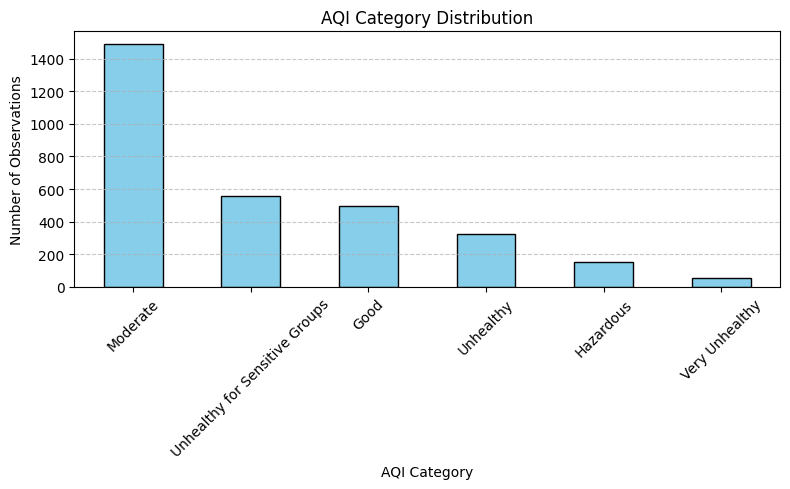

In [1505]:
category_counts = final_combined_df['AQI_Category'].value_counts()

plt.figure(figsize=(8, 5))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('AQI Category Distribution')
plt.xlabel('AQI Category')
plt.ylabel('Number of Observations')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


The "Moderate" AQI category has the highest number of observations, which is a common outcome in urban air quality datasets. This reflects typical, day-to-day air conditions where pollutant levels are elevated due to vehicle traffic, household activities and mild industrial emissions, but not high enough to trigger health warnings for the general population. In many environments, especially outside of extreme weather events or major pollution incidents, air quality tends to fluctuate within this moderate range. This suggests that while the air may not be perfectly clean, it is generally acceptable for most people, with only limited risk for sensitive individuals.

In [1506]:
final_combined_df.isnull().sum()

co                  0
no2                 0
so2                 0
o3                  0
pm10                0
pm25                0
datetime_local      0
AQI               152
AQI_Category        0
dtype: int64

In [1507]:
final_combined_df = final_combined_df.dropna(subset=['AQI'])

In [1508]:
final_combined_df.sample(10)

,co,no2,so2,o3,pm10,pm25,datetime_local,AQI,AQI_Category
594,450.0,23.50,17.86,46.64,17.93,7.01,2025-02-02 17:00,43.0,Good
2031,410.0,5.40,10.35,89.23,11.04,8.13,2025-04-17 22:00,159.0,Unhealthy
1921,670.0,59.75,9.18,40.91,25.88,17.53,2025-04-12 23:00,67.0,Moderate
1547,400.0,9.84,10.10,62.23,33.24,10.65,2025-03-25 02:00,75.0,Moderate
803,460.0,4.94,19.59,43.44,33.78,20.67,2025-02-12 01:00,73.0,Moderate
1356,590.0,55.82,14.61,45.36,56.20,12.13,2025-03-16 08:00,57.0,Moderate
797,500.0,7.39,19.16,46.50,23.42,20.18,2025-02-11 19:00,72.0,Moderate
832,580.0,79.48,19.18,44.19,26.91,14.55,2025-02-13 18:00,78.0,Moderate
261,690.0,83.49,17.46,21.56,33.65,17.03,2025-01-17 19:00,82.0,Moderate
1502,420.0,3.41,8.79,76.18,22.25,6.80,2025-03-23 02:00,119.0,Unhealthy for Sensitive Groups


In [1509]:
y = final_combined_df['AQI']

## Splitting into train/test 🪓
We will use 80% of the data for training and the rest - 20% for testing. This split allows the model to learn from the majority of the data while keeping a separate portion to evaluate its performance on unseen examples, helping us measure how well it generalizes.

In [1510]:
X = final_combined_df[['co', 'no2', 'so2', 'o3', 'pm10', 'pm25']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("There are in total", len(y), "observations, of which", len(X_train), "are now in the train set and", len(X_test), "in the test set.")

There are in total 2929 observations, of which 2343 are now in the train set and 586 in the test set.


## Modelling 🧬

### 1.Random Forest

In [1511]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

rf_mse = mean_squared_error(y_test, y_pred)
rf_r2 = r2_score(y_test, y_pred)

print(f"MSE: {rf_mse:.2f}, R²: {rf_r2:.3f}")

MSE: 10.87, R²: 0.994


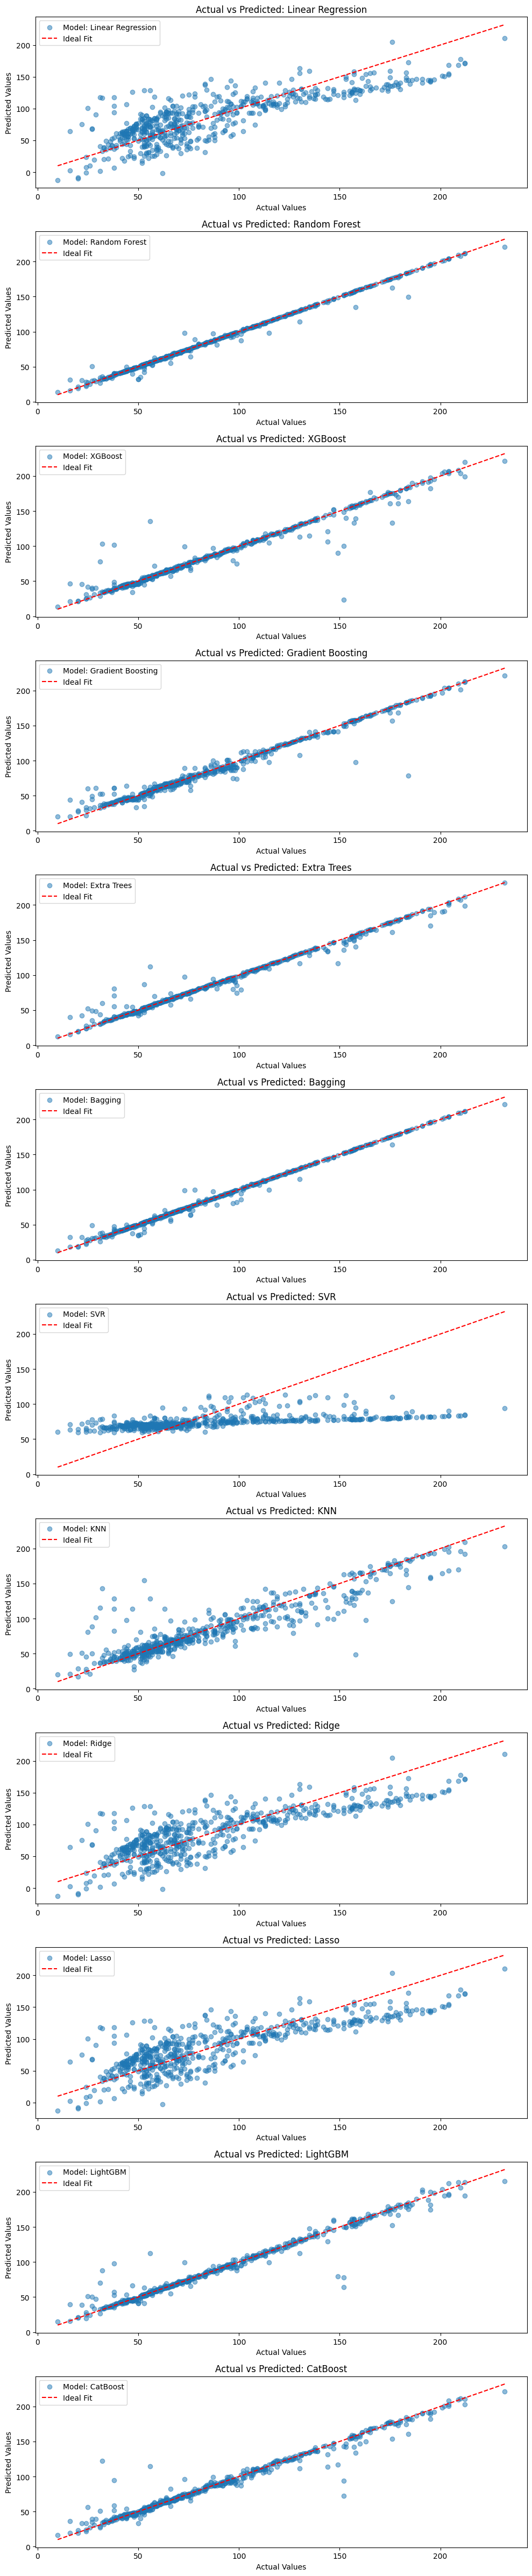

,Model,MAE,MSE,R²
1,Random Forest,9.3928e-01,1.0873e+01,0.994438
5,Bagging,1.0265e+00,1.0222e+01,0.994771
4,Extra Trees,1.9484e+00,3.1677e+01,0.983797
2,XGBoost,2.8618e+00,9.1604e+01,0.953142
10,LightGBM,2.9305e+00,6.8514e+01,0.964953
11,CatBoost,3.1332e+00,6.4143e+01,0.967189
3,Gradient Boosting,3.3135e+00,5.3556e+01,0.972604
7,KNN,1.0268e+01,3.0641e+02,0.843264
0,Linear Regression,2.0456e+01,6.4798e+02,0.668541
8,Ridge,2.0456e+01,6.4798e+02,0.668541


In [1518]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Extra Trees': ExtraTreesRegressor(),
    'Bagging': BaggingRegressor(),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor(),
    'Ridge': Ridge(),
    'Lasso': Lasso()
}

if lgbm_available:
    models['LightGBM'] = LGBMRegressor(force_col_wise=True, verbose=-1)
if catboost_available:
    models['CatBoost'] = CatBoostRegressor(verbose=0)

# Initialize results storage
results = []

# Initialize figure for plots
fig, axes = plt.subplots(len(models), 1, figsize=(10, len(models) * 4))

# Iterate through models
for idx, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results.append((name, mae, mse, r2))

    # Plot actual vs. predicted
    axes[idx].scatter(y_test, preds, alpha=0.5, label=f"Model: {name}")
    axes[idx].plot(
        [y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
        color='red', linestyle='--', label="Ideal Fit"
    )
    axes[idx].set_title(f"Actual vs Predicted: {name}")
    axes[idx].set_xlabel("Actual Values")
    axes[idx].set_ylabel("Predicted Values")
    axes[idx].legend()

plt.tight_layout()
plt.show()

# Create results DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'MAE', 'MSE', 'R²'])
results_df = results_df.sort_values('MAE')

# Style the DataFrame
styled_df = results_df.style.format({
    "MAE": "{:.4e}",
    "MSE": "{:.4e}",
    "R²": "{:.6f}"
}).set_properties(**{
    'text-align': 'center'
}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'center')]
}])

# Display the styled DataFrame
display(styled_df)

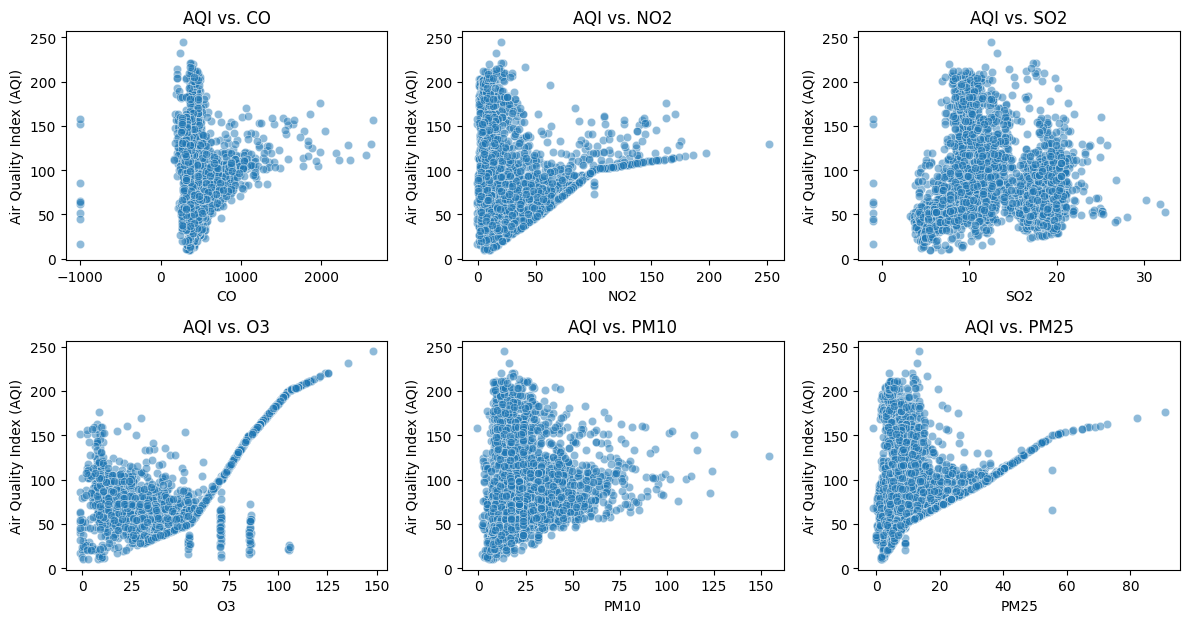

In [1513]:
air_quality_features = ["co", "no2", "so2", "o3", "pm10", "pm25"]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 9))
axes = axes.flatten()

for i, feature in enumerate(air_quality_features):
    seaborn.scatterplot(
        x=final_combined_df[feature],
        y=final_combined_df["AQI"], 
        alpha=0.5,
        ax=axes[i]
    )
    axes[i].set_xlabel(feature.upper())
    axes[i].set_ylabel("Air Quality Index (AQI)")
    axes[i].set_title(f"AQI vs. {feature.upper()}")

for j in range(len(air_quality_features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


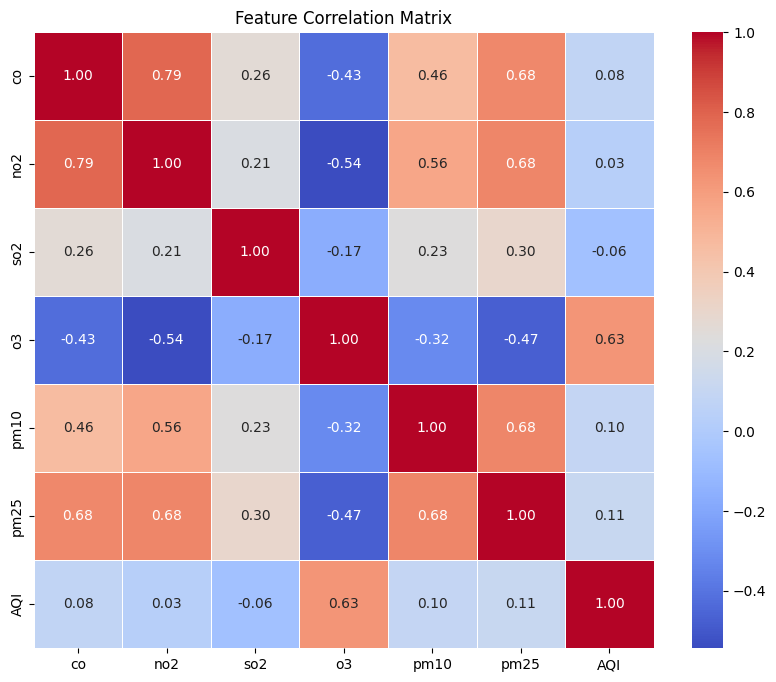

In [ ]:
numeric_df = final_combined_df.select_dtypes(include='number')
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
seaborn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Add titles and labels
plt.title('Feature Correlation Matrix')
plt.show()
